
# Dhaka Stock Exchange — LSTM Next-Day Closing Price Prediction (Colab-Ready)

This notebook builds and evaluates an LSTM model to predict the **next day's closing price** (and optionally multiple future days) for companies listed in the Dhaka Stock Exchange (DSE).

**Expected CSV columns:** `Date, Scrip, Open, High, Low, Close, Volume`  
**Date coverage:** ~2000–2025 (or whatever you have).

### What you'll get
- Clean preprocessing by `Scrip`
- Train/validation/test split (time-aware)
- LSTM model (TensorFlow/Keras) with EarlyStopping + ReduceLROnPlateau
- Metrics (MAE, RMSE, MAPE) on the test set
- Visualizations: history, predictions vs. actuals, and multi-day forecast
- Utility to predict the next N days (`predict_next_days`)

> Tip: Use a **longer history window** (e.g., 90–180 days) for potentially better stability. Start with 60 and iterate.


## 1) Setup

In [34]:

# If you're in Colab, you likely already have TensorFlow 2.x.
# Uncomment the next line to explicitly install/upgrade.
# %pip install -q tensorflow==2.16.* scikit-learn pandas matplotlib

import sys, platform, os, math, warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

warnings.filterwarnings("ignore")

print("Python:", sys.version)
print("Platform:", platform.platform())
print("TensorFlow:", tf.__version__)
print("GPU available:", tf.config.list_physical_devices('GPU'))


Python: 3.11.13 (main, Jun  5 2025, 13:12:00) [GCC 11.2.0]
Platform: Linux-6.16.0-arch2-1-x86_64-with-glibc2.42
TensorFlow: 2.19.0
GPU available: []


## 2) Load Data

In [ ]:
# === OPTION A: Upload CSV manually in Colab ===
# from google.colab import files
# uploaded = files.upload()  # choose your CSV file
# csv_path = list(uploaded.keys())[0]

# === OPTION B: If already in your Drive ===
# from google.colab import drive
# drive.mount('/content/drive')
# csv_path = '/content/drive/MyDrive/path/to/your_dse_data.csv'

# === OPTION C: If you already know the path ===
csv_path = "./dataset/merged_stock_data.csv"  # change this if needed

# Load
df = pd.read_csv(csv_path)

# Basic cleaning and typing
expected_cols = ['Date','Scrip','Open','High','Low','Close','Volume']
missing = [c for c in expected_cols if c not in df.columns]
if missing:
    raise ValueError(f"Missing required columns: {missing}. Found: {list(df.columns)}")

# Parse dates and sort
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df = df.dropna(subset=['Date']).sort_values('Date').reset_index(drop=True)

# Enforce numeric columns
for col in ['Open','High','Low','Close','Volume']:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Drop rows with any NaNs in the core fields
df = df.dropna(subset=['Scrip','Open','High','Low','Close','Volume']).reset_index(drop=True)

print("Rows:", len(df))
print("Date range:", df['Date'].min(), "->", df['Date'].max())
print("Scrip count:", df['Scrip'].nunique())
print("Example Scrips:", df['Scrip'].dropna().unique()[:10])
df.head()

Rows: 1381571
Date range: 2000-01-01 00:00:00 -> 2025-02-26 00:00:00
Scrip count: 464
Example Scrips: ['ACI' 'GQBALLPEN' 'IBNSINA' 'LINDEBD' 'MEGHNACEM' 'MONNOCERA' 'NBL' 'EHL'
 'NTLTUBES' 'RENATA']


,Date,Scrip,Open,High,Low,Close,Volume
0,2000-01-01,ACI,12.674539,13.774594,12.674539,13.631108,19850
1,2000-01-01,GQBALLPEN,38.748000,38.748000,38.748000,38.748000,99
2,2000-01-01,IBNSINA,5.982727,5.982727,5.982727,5.982727,2091
3,2000-01-01,LINDEBD,87.500000,89.000000,87.500000,88.000000,350
4,2000-01-01,MEGHNACEM,10.115501,10.134199,10.096803,10.115501,3000


## 3) Select Company (Scrip) & Quick Look

Scrip: GP
Rows: 3615
Date range: 2009-11-16 00:00:00 -> 2025-02-25 00:00:00


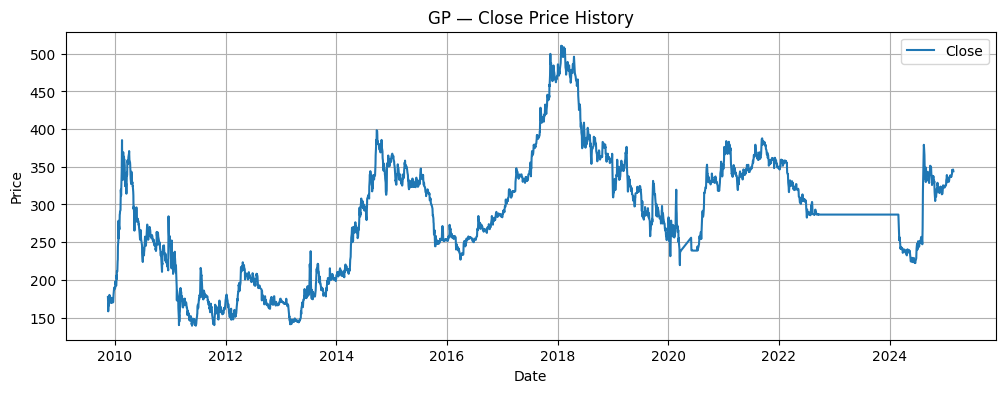

In [36]:

# Choose the company (must match exactly as in your CSV)
TARGET_SCRIP = 'GP'  # <-- change this (e.g., 'GP', 'SQURPHARMA', etc.)

company_df = df[df['Scrip'] == TARGET_SCRIP].copy()
if company_df.empty:
    raise ValueError(f"No rows found for Scrip '{TARGET_SCRIP}'. Check df['Scrip'].unique().")

company_df = company_df.sort_values('Date').reset_index(drop=True)

print(f"Scrip: {TARGET_SCRIP}")
print("Rows:", len(company_df))
print("Date range:", company_df['Date'].min(), "->", company_df['Date'].max())

plt.figure(figsize=(12,4))
plt.plot(company_df['Date'], company_df['Close'], label='Close')
plt.title(f"{TARGET_SCRIP} — Close Price History")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()


## 4) Parameters

In [ ]:

# Window length (days of history) and prediction horizon
SEQ_LEN = 90       # number of past days to use
N_AHEAD = 10        # predict 1 = next day close; set >1 for multi-day forecast

# Split ratios (time-aware split)
TRAIN_RATIO = 0.70
VAL_RATIO   = 0.15  # test gets the remainder

FEATURE_COLS = ['Open','High','Low','Close','Volume']  # can add features here

# Reproducibility
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)


## 5) Prepare Sequences

In [38]:

# Scale features
scaler = MinMaxScaler()
scaled_values = scaler.fit_transform(company_df[FEATURE_COLS].values)
scaled_df = pd.DataFrame(scaled_values, columns=FEATURE_COLS, index=company_df.index)

# Helper to create (X, y) sequences for N_AHEAD prediction of Close
def make_sequences(dataframe, target_col='Close', seq_len=60, n_ahead=1):
    X, y = [], []
    values = dataframe.values
    target_idx = dataframe.columns.get_loc(target_col)
    for i in range(seq_len, len(values) - n_ahead + 1):
        X.append(values[i-seq_len:i, :])             # past window
        y.append(values[i + n_ahead - 1, target_idx])# target at t+n_ahead-1
    return np.array(X), np.array(y)

X_all, y_all = make_sequences(scaled_df[FEATURE_COLS], target_col='Close', seq_len=SEQ_LEN, n_ahead=N_AHEAD)
print("X_all shape:", X_all.shape)  # (samples, seq_len, features)
print("y_all shape:", y_all.shape)  # (samples,)


X_all shape: (3546, 60, 5)
y_all shape: (3546,)


## 6) Train/Val/Test Split (time-aware)

In [39]:

n_samples = X_all.shape[0]
train_end = int(n_samples * TRAIN_RATIO)
val_end   = int(n_samples * (TRAIN_RATIO + VAL_RATIO))

X_train, y_train = X_all[:train_end], y_all[:train_end]
X_val,   y_val   = X_all[train_end:val_end], y_all[train_end:val_end]
X_test,  y_test  = X_all[val_end:], y_all[val_end:]

print("Train:", X_train.shape, y_train.shape)
print("Val:  ", X_val.shape, y_val.shape)
print("Test: ", X_test.shape, y_test.shape)


Train: (2482, 60, 5) (2482,)
Val:   (532, 60, 5) (532,)
Test:  (532, 60, 5) (532,)


## 7) Build & Train LSTM

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 60, 128)        │        68,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 120,129 (469.25 KB)

 Trainable params: 120,129 (469.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 0.0182 - mae: 0.0930 - val_loss: 0.0023 - val_mae: 0.0393 - learning_rate: 0.0010
Epoch 2/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0045 - mae: 0.0498 - val_loss: 0.0013 - val_mae: 0.0260 - learning_rate: 0.0010
Epoch 3/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0040 - mae: 0.0473 - val_loss: 0.0015 - val_mae: 0.0293 - learning_rate: 0.0010
Epoch 4/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0039 - mae: 0.0470 - val_loss: 0.0011 - val_mae: 0.0240 - learning_rate: 0.0010
Epoch 5/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0040 - mae: 0.0476 - val_loss: 0.0011 - val_mae: 0.0239 - learning_rate: 0.0010
Epoch 6/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0038 - mae: 0.0457 - val_loss: 0.0012 - val_mae: 0.0258 - learning_rate: 0.0010
Epoch 7/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0037 - mae: 0.0459 - val_loss: 0.0011 - val_mae: 0.0235 - learning_rate: 0.0010
Epoch 

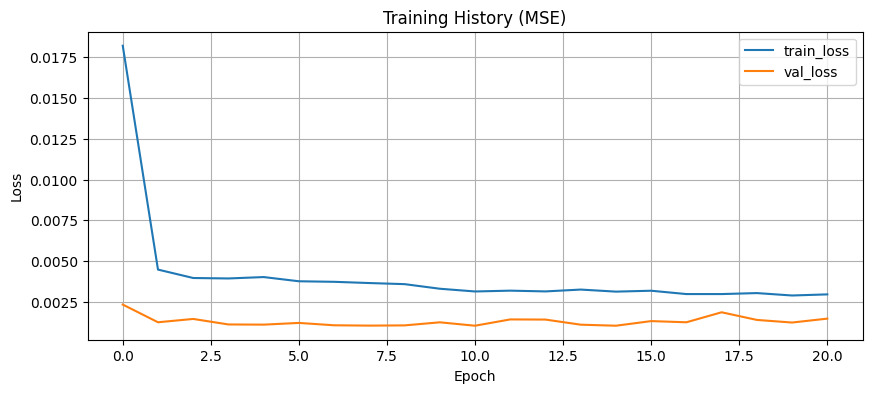

In [40]:

def build_model(seq_len, n_features):
    model = keras.Sequential([
        layers.Input(shape=(seq_len, n_features)),
        layers.LSTM(128, return_sequences=True),
        layers.Dropout(0.2),
        layers.LSTM(64, return_sequences=False),
        layers.Dropout(0.2),
        layers.Dense(32, activation='relu'),
        layers.Dense(1)  # predict scaled Close
    ])
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),
                  loss='mse',
                  metrics=[keras.metrics.MeanAbsoluteError(name='mae')])
    return model

model = build_model(SEQ_LEN, len(FEATURE_COLS))
model.summary()

callbacks = [
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)
]

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=64,
    callbacks=callbacks,
    verbose=1
)

# Plot training history
plt.figure(figsize=(10,4))
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Training History (MSE)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


## 8) Evaluate on Test Set (Inverse-Scaled)

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Test MAE:   7.599476103652666
Test RMSE:  17.00881317195285
Test MAPE:  2.5814522787688428


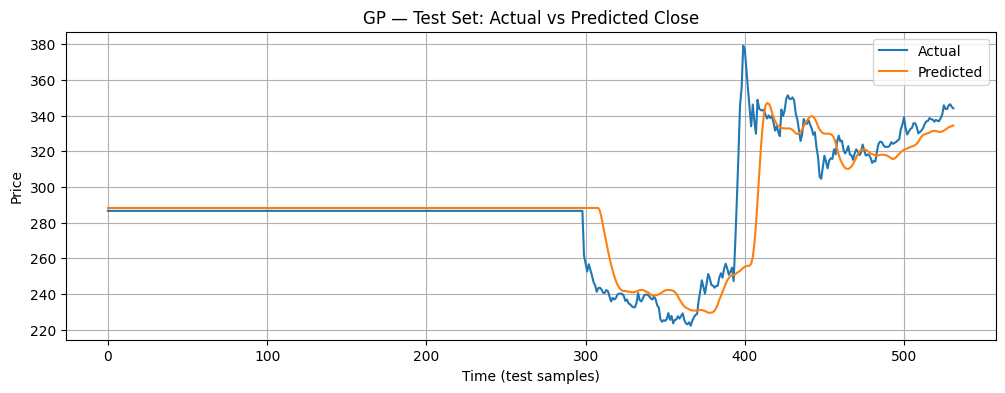

In [41]:

# Predict on test
y_pred_scaled = model.predict(X_test).flatten()

# Inverse transform helper for target column only
def inverse_transform_target(scaled_target_values, scaler, feature_cols, target_col='Close'):
    # Build a dummy array to invert only the target column
    zeros = np.zeros((len(scaled_target_values), len(feature_cols)))
    target_idx = feature_cols.index(target_col)
    zeros[:, target_idx] = scaled_target_values
    inv = scaler.inverse_transform(zeros)
    return inv[:, target_idx]

y_test_inv = inverse_transform_target(y_test, scaler, FEATURE_COLS, target_col='Close')
y_pred_inv = inverse_transform_target(y_pred_scaled, scaler, FEATURE_COLS, target_col='Close')

def rmse(y_true, y_pred):
    return math.sqrt(mean_squared_error(y_true, y_pred))

def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / (y_true + 1e-8))) * 100.0

print("Test MAE:  ", mean_absolute_error(y_test_inv, y_pred_inv))
print("Test RMSE: ", rmse(y_test_inv, y_pred_inv))
print("Test MAPE: ", mape(y_test_inv, y_pred_inv))

# Plot test predictions vs actual
plt.figure(figsize=(12,4))
plt.plot(y_test_inv, label='Actual')
plt.plot(y_pred_inv, label='Predicted')
plt.title(f"{TARGET_SCRIP} — Test Set: Actual vs Predicted Close")
plt.xlabel("Time (test samples)")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()


## 9) Predict Next N Days

In [42]:

def predict_next_days(company_df, scaler, model, feature_cols, seq_len=60, days=1):
    """
    Recursive multi-step forecast. Uses the last `seq_len` rows of scaled features.
    Returns a DataFrame of future dates and predicted Close prices (inverse-scaled).
    """
    # Prepare the latest window
    recent = company_df[feature_cols].values[-seq_len:]
    scaled_recent = scaler.transform(recent)

    preds_scaled = []
    window = scaled_recent.copy()

    # Start from the last known date
    last_date = company_df['Date'].iloc[-1]

    for _ in range(days):
        x = np.expand_dims(window, axis=0)  # shape (1, seq_len, features)
        next_close_scaled = model.predict(x, verbose=0).flatten()[0]
        preds_scaled.append(next_close_scaled)

        # For the next step, we need to append a new row to the window.
        # We only know the predicted Close; we'll carry forward other features from the last row.
        new_row = window[-1].copy()
        close_idx = feature_cols.index('Close')
        new_row[close_idx] = next_close_scaled

        # Slide the window
        window = np.vstack([window[1:], new_row])

    # Inverse transform the predicted Close values
    preds_inv = inverse_transform_target(np.array(preds_scaled), scaler, feature_cols, target_col='Close')

    # Build future date index (calendar days)
    future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=days, freq='D')

    return pd.DataFrame({'Date': future_dates, 'Predicted_Close': preds_inv})

# Example: predict the next day (days=1) or next 7 days (days=7)
future_days = 20   # change as you like
future_df = predict_next_days(company_df, scaler, model, FEATURE_COLS, seq_len=SEQ_LEN, days=future_days)
future_df


,Date,Predicted_Close
0,2025-02-26,339.843036
1,2025-02-27,339.942485
2,2025-02-28,339.817232
3,2025-03-01,339.524266
4,2025-03-02,339.114885
5,2025-03-03,338.633275
6,2025-03-04,338.115252
7,2025-03-05,337.589101
8,2025-03-06,337.075397
9,2025-03-07,336.589003


## 10) Visualize Recent History + Forecast

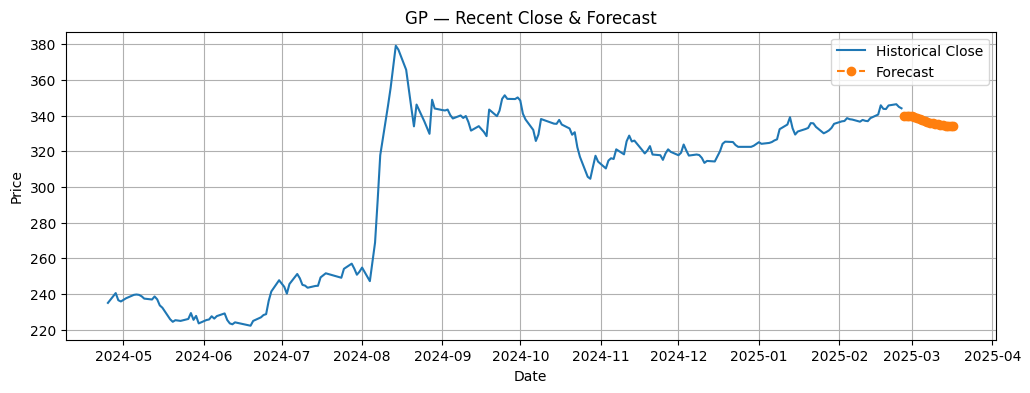

In [43]:

# Combine last chunk of history with future predictions
history_tail = company_df[['Date','Close']].tail(200).copy()  # last 200 days for context
plot_df = history_tail.merge(future_df, on='Date', how='outer')

plt.figure(figsize=(12,4))
plt.plot(plot_df['Date'], plot_df['Close'], label='Historical Close')
plt.plot(plot_df['Date'], plot_df['Predicted_Close'], label='Forecast', linestyle='--', marker='o')
plt.title(f"{TARGET_SCRIP} — Recent Close & Forecast")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()


## 11) Save Model & Scaler (optional)

In [44]:
# Save Keras model
save_dir = "./content/models"
model_path = os.path.join(
    save_dir, f"lstm_{TARGET_SCRIP}_seq{SEQ_LEN}_nahead{N_AHEAD}.keras"
)
model.save(model_path)
print("Saved model to:", model_path)

# Save scaler
import joblib
scaler_path = os.path.join(save_dir, f'scaler_{TARGET_SCRIP}.bin')
joblib.dump(scaler, scaler_path)
print("Saved scaler to:", scaler_path)

Saved model to: ./content/models/lstm_GP_seq60_nahead10.keras
Saved scaler to: ./content/models/scaler_GP.bin



## 12) Tips & Next Steps

- **Try different `SEQ_LEN`** (e.g., 90, 120, 180) and compare metrics.
- **Add features** (technical indicators like moving averages, RSI, etc.) to `FEATURE_COLS`.
- Consider **log-transforming** price-related columns if scales vary widely.
- Experiment with **Bidirectional LSTM**, **GRU**, or **Temporal Convolutional Networks**.
- For **strict walk-forward validation**, retrain on expanding windows before each prediction.
- Markets can be noisy and non-stationary; **no model guarantees accuracy**.
